# Classification Using SNN
#### By The Artificial Intelligence Club (AI) - IIT Madras



This aim of this Problem Statement is to introduce Spiking Neural Networks, which is one of the most used techniques for event data handling. 
Before beginning go thorugh the following articles:
1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9313413/ : It is fairly easy to follow and provides an excellent overview of the field.

2. https://theaisummer.com/spiking-neural-networks/ : A short introduction to different concepts and training parameters related to Spiking Neural Networks.

3. https://arxiv.org/abs/1804.08150 : The base paper for Deep Learning using Spiking Neural Networks.


Some resources to help you in your tasks are:
1. https://pypi.org/project/keras-spiking/
2. https://cnvrg.io/spiking-neural-networks/

##### This coding task might be slightly harder compared to the rest. Fret not! This task shall be evaluated on how much you are able to learn with resplect to implementing a Spiking Neural Network.
##### Even if you do not complete the model deployment, do submit whatever code you complete. 


`Before diving into the code ensure that you copy the notebook to your drive (See the option in File Tab) and that the Runtime Type is set to GPU (Runtime tab -> Change runtime type). To see the importance of GPU in deep learning see this short article.`


From this task, you will:

1.   Learn how spiking neurons are implemented
2.   Understand backpropagation through time, and the associated challenges in SNNs.
3.   Convert a non-spiking model to a spiking model using PyTorchSpiking. 


Sounds like a huge task, but do not worry! Remember to use Google freely to search for any doubts, errors or documentation. This assignment is to check how you can step up to learn new things on the go using publicly available sources.

Ideally at the end, we expect that you just understand the code in EVERY cell. No need to worry greatly about the coding details involved in the task.

Enter your code between areas surrounded by the following comment design
######### YOUR CODE HERE #########


################################



In [47]:
# Install the library that provides the necessary tools for training and running Spiking Neural Networks.
# Install the pytorch_spiking library.
######### YOUR CODE HERE #########
!pip3 install pytorch-spiking
################################

First we import the necessary libraries. We recommend that you check out what these libraries are if they seem unfamiliar. However, fret not if you do not understand these libraries completely. 

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

import pytorch_spiking

torch.manual_seed(0)
np.random.seed(0)

#  Loading Data
First we will load the MNIST data that we shall be using for the task. 

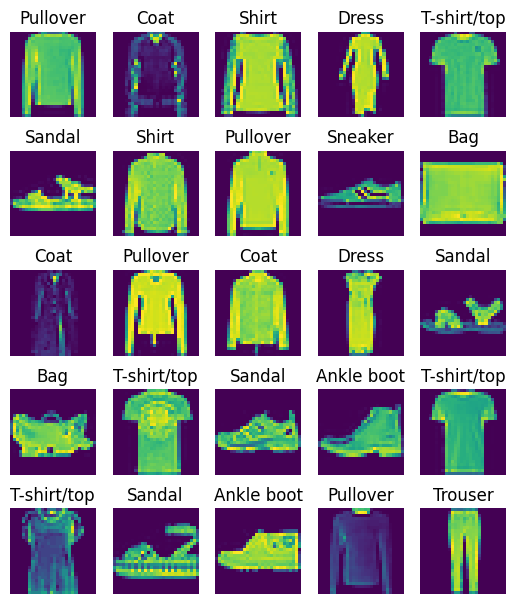

In [49]:
# np.random.seed(10)
train_images, train_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=True, download=True)
)
train_images = np.asarray([np.array(img) for img in train_images], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)

# Do the same loading of data for the test data as well.
######### YOUR CODE HERE #########
test_images, test_labels = zip(*torchvision.datasets.FashionMNIST(".", train=False, download=True))
test_images = np.asarray([np.array(img) for img in test_images], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)

################################

# Normalize images so values are between 0 and 1

######### YOUR CODE HERE #########
train_images = train_images/255
test_images = test_images/255
# print(train_images[0])
################################

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

# Using matplotlib library visualize a randon subset of 25 images from the training dataset with their corresponding labels as the titles for the plots.
# Hint: Use subplot function.

######### YOUR CODE HERE #########
img_indices = np.array([np.random.randint(0, len(train_images)) for i in range(25)])
fig, axes = plt.subplots(5, 5)
for n, i in enumerate(img_indices):
    axes[n//5, n%5].set_title(class_names[train_labels[i]])
    img = train_images[i]
    axes[n//5, n%5].axis('off')
    axes[n//5, n%5].imshow(img)
plt.subplots_adjust(bottom=0, top=1.2)
################################

# Non Spiking Model
Next we’ll build and train a simple non-spiking model to classify the MNIST images.

In [50]:
# Create a model where you define the neural network using PyTorch library. 
# The dataset is Fashion MNIST, whose images are of the size 28*28.
# Create only one hidden layer for the task. 
# The Fashion MNIST has 10 classes that it predicts.

######### YOUR CODE HERE #########
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        logits = self.activation(x)
        return logits
model = NeuralNetwork()
################################

In [51]:

def train(input_model, train_x, test_x):
    minibatch_size = 32
    optimizer = torch.optim.SGD(input_model.parameters(), lr=0.01)

    input_model.train()
    for j in range(10):
        train_acc = 0
        for i in range(train_x.shape[0] // minibatch_size):
            input_model.zero_grad()

            batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
            batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
            batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_model(torch.tensor(batch_in))

            # compute sparse categorical cross entropy loss
            logp = torch.nn.functional.log_softmax(output, dim=-1)
            logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
            loss = -logpy.mean()
            if i==0: print(loss)
            loss.backward()
            optimizer.step()

            train_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )

        train_acc /= i + 1
        print(f"Train accuracy ({j}): {train_acc.numpy()}")

    # compute test accuracy
    input_model.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        batch_in = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        batch_in = batch_in.reshape((-1,) + test_x.shape[1:-2] + (784,))
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output = input_model(torch.tensor(batch_in))

        test_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )

    test_acc /= i + 1
    print(f"Test accuracy: {test_acc.numpy()}")

In [52]:
train_x = train_images
minibatch_size = 100
i = 1
batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
# batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
print(batch_in.shape)
print(train_x.shape[1:-1])

(100, 28, 28)
(28,)


In [53]:
# Call the train function and train on the dataset.
######### YOUR CODE HERE #########

train(model, train_images, test_images)
    
################################

tensor(2.2933, grad_fn=<NegBackward0>)
Train accuracy (0): 0.7123000025749207
tensor(0.5237, grad_fn=<NegBackward0>)
Train accuracy (1): 0.8096333146095276
tensor(0.4247, grad_fn=<NegBackward0>)
Train accuracy (2): 0.8290166854858398
tensor(0.3701, grad_fn=<NegBackward0>)
Train accuracy (3): 0.838283360004425
tensor(0.3363, grad_fn=<NegBackward0>)
Train accuracy (4): 0.8447999954223633
tensor(0.3158, grad_fn=<NegBackward0>)
Train accuracy (5): 0.849566638469696
tensor(0.3036, grad_fn=<NegBackward0>)
Train accuracy (6): 0.8537333607673645
tensor(0.2956, grad_fn=<NegBackward0>)
Train accuracy (7): 0.8574833273887634
tensor(0.2918, grad_fn=<NegBackward0>)
Train accuracy (8): 0.8603166937828064
tensor(0.2920, grad_fn=<NegBackward0>)
Train accuracy (9): 0.8633000254631042
Test accuracy: 0.8500601053237915


The Non-Spiking Neural Network has been created and accuracy has been obtained. It is able to perform well.

Now, the task is to create an equivalent spiking model. 

# Spiking Model
There will be some changes that you will have to take care of:

1.   Add a temporal dimension to the model. Find out how to add temporal dimension to a model bacause SNNs work on temporal data.
2.   Activation functions make sense for Deep learning models. However, when transforming to Spiking Neural Networks, they have to replaced with an equivalent form. 

Performing the above steps ensure that the inference the model gives upon test data will be based on laws of Spiking Neural Networks.
But, remember that training on a non-spiking model and inferencing from a spiking model gives poorest results. (Show evidence).

Try implementing a network which used spiking model for training as well as inferencing.



### Bonus if you are able to think out of the box and some suggest some innovative ideas to go about solving the above problem apart from the prompts specified.

In [54]:
class SpikingNetwork(nn.Module):
    def __init__(self, dt = 0.001):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation = nn.Sequential(
            nn.Linear(28*28, 128),
            pytorch_spiking.SpikingActivation(nn.ReLU(), spiking_aware_training = True, dt=dt), # Rate encoding
            pytorch_spiking.TemporalAvgPool(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        logits = self.activation(x)
        return logits
model_spiking = SpikingNetwork(dt=0.1)
# class Spiking2(nn.Module)

In [55]:
steps = 10
train_sequences = np.tile(train_images[:, None], (1, steps, 1, 1))
test_sequences = np.tile(test_images[:, None], (1, steps, 1, 1))
train(model_spiking, train_sequences, test_sequences)

tensor(2.2800, grad_fn=<NegBackward0>)
Train accuracy (0): 0.6794666647911072
tensor(0.5871, grad_fn=<NegBackward0>)
Train accuracy (1): 0.7875833511352539
tensor(0.5086, grad_fn=<NegBackward0>)
Train accuracy (2): 0.8090333342552185
tensor(0.4633, grad_fn=<NegBackward0>)
Train accuracy (3): 0.8185166716575623
tensor(0.3864, grad_fn=<NegBackward0>)
Train accuracy (4): 0.8251166939735413
tensor(0.4644, grad_fn=<NegBackward0>)
Train accuracy (5): 0.8298666477203369
tensor(0.3403, grad_fn=<NegBackward0>)
Train accuracy (6): 0.8337500095367432
tensor(0.3840, grad_fn=<NegBackward0>)
Train accuracy (7): 0.8374833464622498
tensor(0.2794, grad_fn=<NegBackward0>)
Train accuracy (8): 0.8413833379745483
tensor(0.2967, grad_fn=<NegBackward0>)
Train accuracy (9): 0.8433499932289124
Test accuracy: 0.8344351053237915


In [56]:
# Speed comparison
for n, i in enumerate(img_indices):
    axes[n//5, n%5].set_title(class_names[train_labels[i]])
    img = train_images[i]
    axes[n//5, n%5].axis('off')
    axes[n//5, n%5].imshow(img)
plt.subplots_adjust(bottom=0, top=1.2)
def test(input_model, train_x, test_x):
    minibatch_size = 32
    optimizer = torch.optim.SGD(input_model.parameters(), lr=0.01)

    # input_model.train()
    # for j in range(10):
    #     train_acc = 0
    #     for i in range(train_x.shape[0] // minibatch_size):
    #         input_model.zero_grad()

    #         batch_in = train_x[i * minibatch_size : (i + 1) * minibatch_size]
    #         # flatten images
    #         batch_in = batch_in.reshape((-1,) + train_x.shape[1:-2] + (784,))
    #         batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
    #         output = input_model(torch.tensor(batch_in))

    #         # compute sparse categorical cross entropy loss
    #         logp = torch.nn.functional.log_softmax(output, dim=-1)
    #         logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
    #         loss = -logpy.mean()
    #         if i==0: print(loss)
    #         loss.backward()
    #         optimizer.step()

    #         train_acc += torch.mean(
    #             torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
    #         )

    #     train_acc /= i + 1
    #     print(f"Train accuracy ({j}): {train_acc.numpy()}")

    # compute test accuracy
    input_model.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
        batch_in = test_x[i * minibatch_size : (i + 1) * minibatch_size]
        batch_in = batch_in.reshape((-1,) + test_x.shape[1:-2] + (784,))
        batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
        output = input_model(torch.tensor(batch_in))

        test_acc += torch.mean(
            torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
        )

    test_acc /= i + 1
    print(f"Test accuracy: {test_acc.numpy()}")


<Figure size 640x480 with 0 Axes>

In [57]:
test(model_spiking, train_sequences, test_sequences)


Test accuracy: 0.8347355723381042


In [58]:
test(model, train_images, test_images)

Test accuracy: 0.8500601053237915
